In [1]:
import re
import warnings
from string import punctuation

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import StratifiedKFold

warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv("../data/raw/train.csv", index_col="PassengerId")
test = pd.read_csv("../data/raw/test.csv", index_col="PassengerId")
data = pd.concat([train, test], keys=["train", "test"])
target = "Survived"

In [3]:
train

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


In [4]:
test

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...
1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S


In [5]:
data.loc["train"].groupby(["Sex", "Pclass"])["Age"].median().unstack()

Pclass,1,2,3
Sex,,,
female,35.0,28.0,21.5
male,40.0,30.0,25.0


In [6]:
medians = data.loc["train"].groupby(["Sex", "Pclass"])["Age"].median()
median_col = data.join(medians, on=["Sex", "Pclass"], rsuffix="_med")["Age_med"]
data["Age"] = data["Age"].combine_first(median_col)

In [7]:
data["Embarked"] = data["Embarked"].fillna(data["Embarked"].value_counts().idxmax())

In [8]:
medians = data.groupby(["Pclass", "Parch", "SibSp"])["Fare"].median()
median_col = data.join(medians, on=["Pclass", "Parch", "SibSp"], rsuffix="_med")["Fare_med"]
data["Fare"] = data["Fare"].combine_first(median_col)

In [9]:
data["Deck"] = data["Cabin"].apply(lambda s: s[0] if pd.notnull(s) else "M")

In [10]:
data["Deck"] = (
    data["Deck"]
        .replace(["A", "B", "C", "T"], "ABC")
        .replace(["D", "E"], "DE")
        .replace(["F", "G"], "FG")
)

In [11]:
data = data.drop(columns=["Cabin"])

In [12]:
data.isnull().sum()

Survived    418
Pclass        0
Name          0
Sex           0
Age           0
SibSp         0
Parch         0
Ticket        0
Fare          0
Embarked      0
Deck          0
dtype: int64

In [13]:
data["Fare"] = pd.qcut(data["Fare"], 13)

In [14]:
data["Age"] = pd.qcut(data["Age"], 10)

In [15]:
data["FamilySize"] = data["SibSp"] + data["Parch"] + 1

In [16]:
data["FamilySizeGroup"] = data["FamilySize"].case_when(
    [
        (data["FamilySize"].eq(1), "Alone"),
        (data["FamilySize"].le(4), "Small"),
        (data["FamilySize"].le(6), "Medium"),
        (data["FamilySize"].gt(6), "Large"),
    ]
)

In [17]:
data["TicketFrequency"] = data.groupby("Ticket")["Ticket"].transform("count")

In [18]:
data["Title"] = data["Name"].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
data["IsMarried"] = data["Title"].eq("Mrs").astype(int)
data["Title"] = data["Title"].replace(["Miss", "Mrs", "Ms", "Mlle", "Lady", "Mme", "the Countess", "Dona"], "Mrs/Ms/Miss")
data["Title"] = data["Title"].replace(["Dr", "Col", "Major", "Jonkheer", "Capt", "Sir", "Don", "Rev"], "Dr/Military/Noble/Clergy")

In [19]:
names = data["Name"].str.split(",", expand=True)[0]
data["Family"] = names.str.replace(f"[{re.escape(punctuation)}]", "", regex=True)

In [20]:
non_unique_families = pd.Series([x for x in data.loc["train", "Family"].unique() if x in data.loc["test", "Family"].unique()], name="Family")
non_unique_tickets = pd.Series([x for x in data.loc["train", "Ticket"].unique() if x in data.loc["test", "Ticket"].unique()], name="Ticket")

In [21]:
family_survival_rates = data.loc["train"].groupby("Family")[["FamilySize", "Survived"]].mean()
ticket_survival_rates = data.loc["train"].groupby("Ticket")[["TicketFrequency", "Survived"]].mean()

In [22]:
family_rates = family_survival_rates.loc[family_survival_rates["FamilySize"] > 1, "Survived"].filter(non_unique_families, axis="index")
ticket_rates = ticket_survival_rates.loc[ticket_survival_rates["TicketFrequency"] > 1, "Survived"].filter(non_unique_tickets, axis="index")

In [23]:
data = data.join(family_rates.rename("FamilySurvivalRate"), on="Family")
data = data.join(ticket_rates.rename("TicketSurvivalRate"), on="Ticket")

In [24]:
data["FamilySurvivalRate"] = data["FamilySurvivalRate"].fillna(data.loc["train", "Survived"].mean())
data["TicketSurvivalRate"] = data["TicketSurvivalRate"].fillna(data.loc["train", "Survived"].mean())

In [25]:
data["FamilySurvivalRateNA"] = data["Family"].isin(family_rates.index).astype(int)
data["TicketSurvivalRateNA"] = data["Ticket"].isin(ticket_rates.index).astype(int)

In [26]:
data["SurvivalRate"] = (data["FamilySurvivalRate"] + data["TicketSurvivalRate"]) / 2
data["SurvivalRateNA"] = (data["FamilySurvivalRateNA"] + data["TicketSurvivalRateNA"]) / 2

In [27]:
data

Survived  Pclass  \
      PassengerId                     
train 1                 0.0       3   
      2                 1.0       1   
      3                 1.0       3   
      4                 1.0       1   
      5                 0.0       3   
...                     ...     ...   
test  1305              NaN       3   
      1306              NaN       1   
      1307              NaN       3   
      1308              NaN       3   
      1309              NaN       3   

                                                                Name     Sex  \
      PassengerId                                                              
train 1                                      Braund, Mr. Owen Harris    male   
      2            Cumings, Mrs. John Bradley (Florence Briggs Th...  female   
      3                                       Heikkinen, Miss. Laina  female   
      4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)  female   
      5                                     Allen, Mr. William Henry    male   
...                                                              ...     ...   
test  1305                                        Spector, Mr. Woolf    male   
      1306                              Oliva y Ocana, Dona. Fermina  female   
      1307                              Saether, Mr. Simon Sivertsen    male   
      1308                                       Ware, Mr. Frederick    male   
      1309                                  Peter, Master. Michael J    male   

                            Age  SibSp  Parch              Ticket  \
      PassengerId                                                   
train 1            (21.0, 22.0]      1      0           A/5 21171   
      2            (34.0, 40.0]      1      0            PC 17599   
      3            (25.0, 26.0]      0      0    STON/O2. 3101282   
      4            (34.0, 40.0]      1      0              113803   
      5            (34.0, 40.0]      0      0              373450   
...                         ...    ...    ...                 ...   
test  1305         (22.0, 25.0]      0      0           A.5. 3236   
      1306         (34.0, 40.0]      0      0            PC 17758   
      1307         (34.0, 40.0]      0      0  SOTON/O.Q. 3101262   
      1308         (22.0, 25.0]      0      0              359309   
      1309         (22.0, 25.0]      1      1                2668   

                                Fare Embarked  ... TicketFrequency  \
      PassengerId                              ...                   
train 1               (-0.001, 7.25]        S  ...               1   
      2             (56.496, 83.475]        C  ...               2   
      3                (7.896, 8.05]        S  ...               1   
      4             (34.075, 56.496]        S  ...               2   
      5                (7.896, 8.05]        S  ...               1   
...                              ...      ...  ...             ...   
test  1305             (7.896, 8.05]        S  ...               1   
      1306         (83.475, 512.329]        C  ...               3   
      1307            (-0.001, 7.25]        S  ...               1   
      1308             (7.896, 8.05]        S  ...               1   
      1309           (15.742, 23.25]        C  ...               3   

                         Title IsMarried         Family FamilySurvivalRate  \
      PassengerId                                                            
train 1                     Mr         0         Braund           0.383838   
      2            Mrs/Ms/Miss         1        Cumings           1.000000   
      3            Mrs/Ms/Miss         0      Heikkinen           0.383838   
      4            Mrs/Ms/Miss         1       Futrelle           0.383838   
      5                     Mr         0          Allen           0.383838   
...                        ...       ...            ...                ...   
test  1305                  Mr       

In [28]:
data.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Embarked', 'Deck', 'FamilySize', 'FamilySizeGroup',
       'TicketFrequency', 'Title', 'IsMarried', 'Family', 'FamilySurvivalRate',
       'TicketSurvivalRate', 'FamilySurvivalRateNA', 'TicketSurvivalRateNA',
       'SurvivalRate', 'SurvivalRateNA'],
      dtype='object')

In [29]:
data = data.drop(columns=["Name", "SibSp", "Parch", "Ticket", "FamilySize", "Family", "FamilySurvivalRate", "TicketSurvivalRate", "FamilySurvivalRateNA", "TicketSurvivalRateNA"])

In [30]:
ord_features = ["Pclass", "Age", "Fare"]
cat_features = ["Sex", "Deck", "Embarked", "Title", "FamilySizeGroup"]

In [31]:
d = data.copy()

#for feature in nonnumeric_features:
#    d[feature] = LabelEncoder().fit_transform(d[feature])

In [32]:
encoder = ColumnTransformer(
    [
        ("ordinal", OrdinalEncoder(), ord_features),
        ("onehot", OneHotEncoder(handle_unknown="warn"), cat_features),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
)

pipe = Pipeline([
    ("encoding", encoder),
    ("scaling", StandardScaler()),
])

In [33]:
train_trans = pipe.fit_transform(d.loc["train"].drop(columns="Survived"))

In [34]:
test_trans = pipe.transform(d.loc["test"])

In [35]:
colnames = pipe.get_feature_names_out()

In [36]:
X_train = pd.DataFrame(train_trans, columns=colnames, index=d.loc["train"].index)

In [37]:
X_test = pd.DataFrame(test_trans, columns=colnames, index=d.loc["test"].index)

In [38]:
y_train = d.loc["train", "Survived"]

In [39]:
X_train

,Pclass,Age,Fare,Sex_female,Sex_male,Deck_ABC,Deck_DE,Deck_FG,Deck_M,Embarked_C,...,Title_Mr,Title_Mrs/Ms/Miss,FamilySizeGroup_Alone,FamilySizeGroup_Large,FamilySizeGroup_Medium,FamilySizeGroup_Small,TicketFrequency,IsMarried,SurvivalRate,SurvivalRateNA
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0.827377,-0.790112,-1.556514,-0.737695,0.737695,-0.398306,-0.280522,-0.139466,0.544925,-0.482043,...,0.850532,-0.735882,-1.231645,-0.169907,-0.208148,1.432260,-0.624404,-0.403962,-0.096309,-0.589388
2,-1.566107,0.939592,1.348169,1.355574,-1.355574,2.510633,-0.280522,-0.139466,-1.835115,2.074505,...,-1.175735,1.358913,-1.231645,-0.169907,-0.208148,1.432260,-0.067503,2.475480,2.985508,2.016789
3,0.827377,-0.098230,-0.764328,1.355574,-1.355574,-0.398306,-0.280522,-0.139466,0.544925,-0.482043,...,-1.175735,1.358913,0.811922,-0.169907,-0.208148,-0.698197,-0.624404,-0.403962,-0.096309,-0.589388
4,-1.566107,0.939592,1.084107,1.355574,-1.355574,2.510633,-0.280522,-0.139466,-1.835115,-0.482043,...,-1.175735,1.358913,-1.231645,-0.169907,-0.208148,1.432260,-0.067503,2.475480,-0.096309,-0.589388
5,0.827377,0.939592,-0.764328,-0.737695,0.737695,-0.398306,-0.280522,-0.139466,0.544925,-0.482043,...,0.850532,-0.735882,0.811922,-0.169907,-0.208148,-0.698197,-0.624404,-0.403962,-0.096309,-0.589388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,-0.369365,0.247711,-0.236204,-0.737695,0.737695,-0.398306,-0.280522,-0.139466,0.544925,-0.482043,...,-1.175735,-0.735882,0.811922,-0.169907,-0.208148,-0.698197,-0.624404,-0.403962,-0.096309,-0.589388
888,-1.566107,-1.136053,0.820045,1.355574,-1.355574,2.510633,-0.280522,-0.139466,-1.835115,-0.482043,...,-1.175735,1.358913,0.811922,-0.169907,-0.208148,-0.698197,-0.624404,-0.403962,-0.096309,-0.589388
889,0.827377,-0.790112,0.555983,1.355574,-1.355574,-0.398306,-0.280522,-0.139466,0.544925,-0.482043,...,-1.175735,1.358913,-1.231645,-0.169907,-0.208148,1.432260,1.046299,-0.403962,-2.016129,2.016789


In [40]:
colnames

array(['Pclass', 'Age', 'Fare', 'Sex_female', 'Sex_male', 'Deck_ABC',
       'Deck_DE', 'Deck_FG', 'Deck_M', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'Title_Dr/Military/Noble/Clergy', 'Title_Master',
       'Title_Mr', 'Title_Mrs/Ms/Miss', 'FamilySizeGroup_Alone',
       'FamilySizeGroup_Large', 'FamilySizeGroup_Medium',
       'FamilySizeGroup_Small', 'TicketFrequency', 'IsMarried',
       'SurvivalRate', 'SurvivalRateNA'], dtype=object)

In [41]:
len(colnames)

24

In [42]:
model = RandomForestClassifier(
    criterion='gini', 
    n_estimators=1750,
    max_depth=7,
    min_samples_split=6,
    min_samples_leaf=6,
    max_features='sqrt',
    oob_score=True,
    random_state=1234,
    n_jobs=-1,
)

In [43]:
kfold = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
oob = 0
fprs, tprs, scores = [], [], []
probs = np.empty([X_test.shape[0], 10])
importances = np.empty([X_test.shape[1], 5])

for fold, (trn_idx, val_idx) in enumerate(kfold.split(X_train, y_train), 1):
    print("Fold", fold)
    model.fit(X_train.iloc[trn_idx], y_train.iloc[trn_idx])
    
    trn_fpr, trn_tpr, trn_thresholds = roc_curve(y_train.iloc[trn_idx], model.predict_proba(X_train.iloc[trn_idx])[:, 1])
    trn_auc_score = auc(trn_fpr, trn_tpr)

    val_fpr, val_tpr, val_thresholds = roc_curve(y_train.iloc[val_idx], model.predict_proba(X_train.iloc[val_idx])[:, 1])
    val_auc_score = auc(val_fpr, val_tpr)

    scores.append((trn_auc_score, val_auc_score))
    fprs.append(val_fpr)
    tprs.append(val_tpr)

    probs[:, [(fold-1)*2, (fold-1)*2+1]] = model.predict_proba(X_test)
    importances[:, fold-1] = model.feature_importances_
    
    print(f"Fold {fold} OOB score: {model.oob_score_:.4f}")
    oob += model.oob_score_ / 5

print("Average OOB score:", oob)

Fold 1
Fold 1 OOB score: 0.8413
Fold 2
Fold 2 OOB score: 0.8569
Fold 3
Fold 3 OOB score: 0.8429
Fold 4
Fold 4 OOB score: 0.8429
Fold 5
Fold 5 OOB score: 0.8457
Average OOB score: 0.8459582867138378


In [44]:
imp = pd.DataFrame(importances, index=X_train.columns).stack()
imp.index.names = ["Feature", "Fold"]
imp = imp.reset_index(name="Importance")

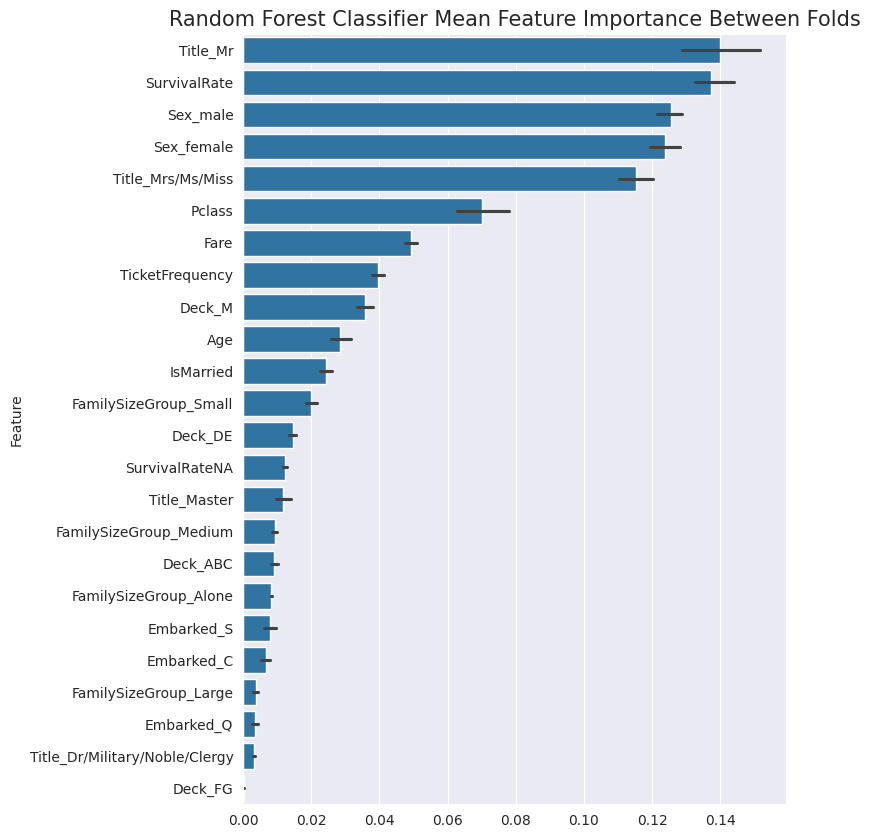

In [45]:
plt.figure(figsize=(7, 10))
sns.barplot(x="Importance", y="Feature", data=imp, order=imp.groupby("Feature")["Importance"].mean().sort_values(ascending=False).index)
plt.xlabel("")
plt.title('Random Forest Classifier Mean Feature Importance Between Folds', size=15)
plt.show()

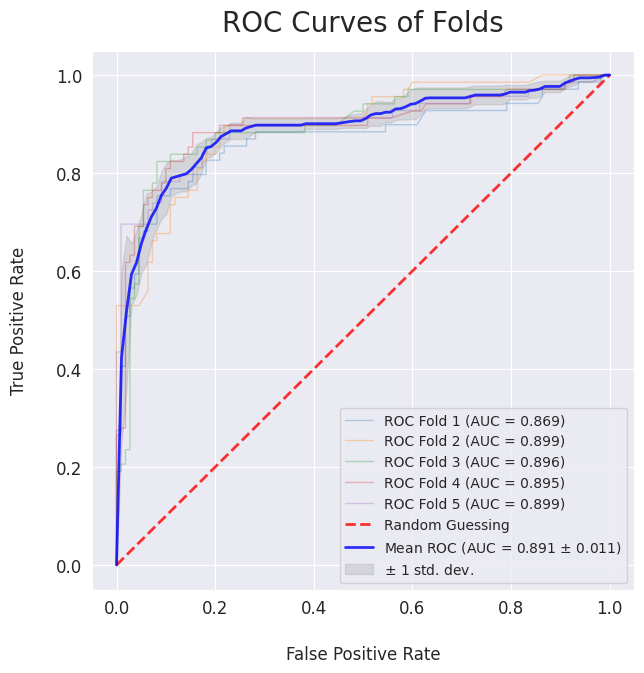

In [46]:
def plot_roc_curve(fprs, tprs):
    
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(7, 7))
    
    # Plotting ROC for each fold and computing AUC scores
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs), 1):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC Fold {} (AUC = {:.3f})'.format(i, roc_auc))
        
    # Plotting ROC for random guessing
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8, label='Random Guessing')
    
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    # Plotting the mean ROC
    ax.plot(mean_fpr, mean_tpr, color='b', label='Mean ROC (AUC = {:.3f} $\pm$ {:.3f})'.format(mean_auc, std_auc), lw=2, alpha=0.8)
    
    # Plotting the standard deviation around the mean ROC Curve
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label='$\pm$ 1 std. dev.')
    
    ax.set_xlabel('False Positive Rate', size=12, labelpad=20)
    ax.set_ylabel('True Positive Rate', size=12, labelpad=20)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])

    ax.set_title('ROC Curves of Folds', size=20, y=1.02)
    ax.legend(loc='lower right', prop={'size': 10})
    
    plt.show()

plot_roc_curve(fprs, tprs)

In [47]:
p_survival = probs[:, range(1, 10, 2)].mean(axis=1)

In [48]:
prediction = (p_survival >= 0.5).astype(int)

In [49]:
pd.DataFrame({"Survived": prediction}, index=X_test.index).to_csv("submission.csv")